<a href="https://colab.research.google.com/github/pibieta/ML-course/blob/master/NovosPiratas/Walmart_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Walmart Challenge
---
Juan Pablo Ibieta Jimenez

NUSP = 8291104

In [0]:
import datetime
import random
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('white')


from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost as xgb


def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)


## Get Data
we request raw data from [this](https://github.com/pibieta/ML-course/tree/master/NovosPiratas/Walmart) Github repo

In [0]:
# urls
url_features = 'https://raw.githubusercontent.com/pibieta/ML-course/master/NovosPiratas/Walmart/features.csv'
url_stores  = 'https://raw.githubusercontent.com/pibieta/ML-course/master/NovosPiratas/Walmart/stores.csv'
url_train = 'https://raw.githubusercontent.com/pibieta/ML-course/master/NovosPiratas/Walmart/train.csv'
url_test = 'https://raw.githubusercontent.com/pibieta/ML-course/master/NovosPiratas/Walmart/test.csv'

In [0]:
# Read data as dataframes
train = pd.read_csv(url_train, parse_dates=[2])
test = pd.read_csv(url_test, parse_dates= [2])
stores = pd.read_csv(url_stores)
features = pd.read_csv(url_features, parse_dates=[1])

## Exploratory Data Analysis
Train e test têm as mesmas colunas além de `Weekly_sales` que é o que devemos prever.

Informações adicionais sobre as lojas e alguns indicadores econômicos estão contidas nos arquivos `features` e `stores`. Incluiremos essas informações como parte do dataset de treino e do de teste.

In [4]:
train.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
dtype: object

In [5]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [6]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [7]:
train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

In [0]:
df_train = pd.merge(train, features, on=['Store', 'Date', 'IsHoliday'], how = 'inner')
df_train = pd.merge(df_train, stores, on=['Store'], how = 'inner')

df_test = pd.merge(test, features, on=['Store', 'Date', 'IsHoliday'], how = 'inner')
df_test = pd.merge(df_test, stores, on=['Store'], how = 'inner')

In [9]:
df_train.shape

(421570, 16)

In [10]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.000,11.000000,22.00000,33.000000,45.000000
Dept,421570.0,44.260317,30.492054,1.000,18.000000,37.00000,74.000000,99.000000
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,2079.650000,7612.03000,20205.852500,693099.360000
Temperature,421570.0,60.090059,18.447931,-2.060,46.680000,62.09000,74.280000,100.140000
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.933000,3.45200,3.738000,4.468000
MarkDown1,150681.0,7246.420196,8291.221345,0.270,2240.270000,5347.45000,9210.900000,88646.760000
MarkDown2,111248.0,3334.628621,9475.357325,-265.760,41.600000,192.00000,1926.940000,104519.540000
MarkDown3,137091.0,1439.421384,9623.078290,-29.100,5.080000,24.60000,103.990000,141630.610000
MarkDown4,134967.0,3383.168256,6292.384031,0.220,504.220000,1481.31000,3595.040000,67474.850000
MarkDown5,151432.0,4628.975079,5962.887455,135.160,1878.440000,3359.45000,5563.800000,108519.280000


 NaN values: as colunas `Markdown` contêm valores NaN

In [11]:
df_train.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

In [12]:
df_train.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
dtype: object

Vamos separar a coluna `Date` em três outras colunas contendo o Ano, Mês e Semana. Será conveniente no futuro.


In [13]:
df_train['year'] = df_train.Date.dt.year
df_train['month'] = df_train.Date.dt.month
df_train['week'] = df_train.Date.dt.week
df_train['train'] = True

# pythonic
df_test = df_test.assign(year = df_test.Date.dt.year, month =  df_test.Date.dt.month, week=df_test.Date.dt.week )
df_test['train'] = False
df_test.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,year,month,week,train
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,2012,11,44,False
1,1,2,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,2012,11,44,False
2,1,3,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,2012,11,44,False
3,1,4,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,2012,11,44,False
4,1,5,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,2012,11,44,False


In [14]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,year,month,week,train
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,5,True
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,5,True
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,5,True
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,5,True
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,5,True


Vamos juntar os dois datasets em um só, preenchendo com `0` os `NaN` values. Isto não é um problema para os casos de teste pois depois separaremos o dataframe novamente antes de treinar os modelos. Sobre as colunas `Markdown#` assumimos que o valor `0.0` é equivalente a não ter `Markdown`

In [0]:
df = pd.concat([df_train, df_test], axis = 0, sort=False)
df = df.fillna(0)

In [16]:
df.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,year,month,week,train
115059,45,93,2013-07-26,0.0,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,0.0,0.0,B,118221,2013,7,30,False
115060,45,94,2013-07-26,0.0,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,0.0,0.0,B,118221,2013,7,30,False
115061,45,95,2013-07-26,0.0,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,0.0,0.0,B,118221,2013,7,30,False
115062,45,97,2013-07-26,0.0,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,0.0,0.0,B,118221,2013,7,30,False
115063,45,98,2013-07-26,0.0,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,0.0,0.0,B,118221,2013,7,30,False


### Correlation Matrix
Nos dá uma ideia da correlação entre as variáveis. Em particular,  estamos interessados na coluna (ou fila) `Weekly_Sales`.

In [17]:
corr = df.corr()
corr

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,year,month,week,train
Store,1.000000,0.023061,-0.072140,-0.000671,-0.048379,0.073123,-0.065246,-0.042013,-0.023277,-0.041543,0.000356,-0.133847,0.133553,-0.183736,0.002782,0.000520,0.000554,-0.001208
Dept,0.023061,1.000000,0.124276,0.001002,0.004151,0.003273,0.000492,0.000384,0.000852,0.001163,0.001332,-0.005665,0.003475,-0.002004,0.002797,0.001444,0.001433,-0.001065
Weekly_Sales,-0.072140,0.124276,1.000000,0.007097,0.039928,-0.065185,-0.053529,-0.027302,-0.005122,-0.024305,-0.011073,0.103451,0.144122,0.205868,-0.226378,0.050738,0.046927,0.309807
IsHoliday,-0.000671,0.001002,0.007097,1.000000,-0.163056,-0.077976,0.112120,0.215831,0.329651,0.102324,-0.012554,0.059264,0.055320,0.000345,-0.052596,0.142878,0.149182,-0.011491
Temperature,-0.048379,0.004151,0.039928,-0.163056,1.000000,0.099235,-0.104930,-0.220472,-0.061890,-0.078796,-0.016038,-0.048878,-0.058701,-0.058202,-0.037865,0.225541,0.225175,0.135093
Fuel_Price,0.073123,0.003273,-0.065185,-0.077976,0.099235,1.000000,0.269523,0.029201,0.028873,0.152282,0.100314,-0.219331,-0.121736,0.009058,0.657853,-0.064187,-0.054194,-0.210057
MarkDown1,-0.065246,0.000492,-0.053529,0.112120,-0.104930,0.269523,1.000000,0.153091,-0.021764,0.825862,0.174847,-0.040013,-0.131771,0.199747,0.445504,-0.132286,-0.137436,-0.275050
MarkDown2,-0.042013,0.000384,-0.027302,0.215831,-0.220472,0.029201,0.153091,1.000000,-0.017901,0.065154,0.047690,0.023112,-0.020535,0.104394,0.154407,-0.028154,-0.023820,-0.138269
MarkDown3,-0.023277,0.000852,-0.005122,0.329651,-0.061890,0.028873,-0.021764,-0.017901,1.000000,-0.016410,0.009042,0.014653,-0.005911,0.041505,0.026240,0.142238,0.150387,-0.090314
MarkDown4,-0.041543,0.001163,-0.024305,0.102324,-0.078796,0.152282,0.825862,0.065154,-0.016410,1.000000,0.116872,-0.054137,-0.099436,0.145301,0.293940,-0.143169,-0.153431,-0.160028


In [18]:
corr.loc['Weekly_Sales'].sort_values(ascending=False)

Weekly_Sales    1.000000
train           0.309807
Size            0.205868
Unemployment    0.144122
Dept            0.124276
CPI             0.103451
month           0.050738
week            0.046927
Temperature     0.039928
IsHoliday       0.007097
MarkDown3      -0.005122
MarkDown5      -0.011073
MarkDown4      -0.024305
MarkDown2      -0.027302
MarkDown1      -0.053529
Fuel_Price     -0.065185
Store          -0.072140
year           -0.226378
Name: Weekly_Sales, dtype: float64

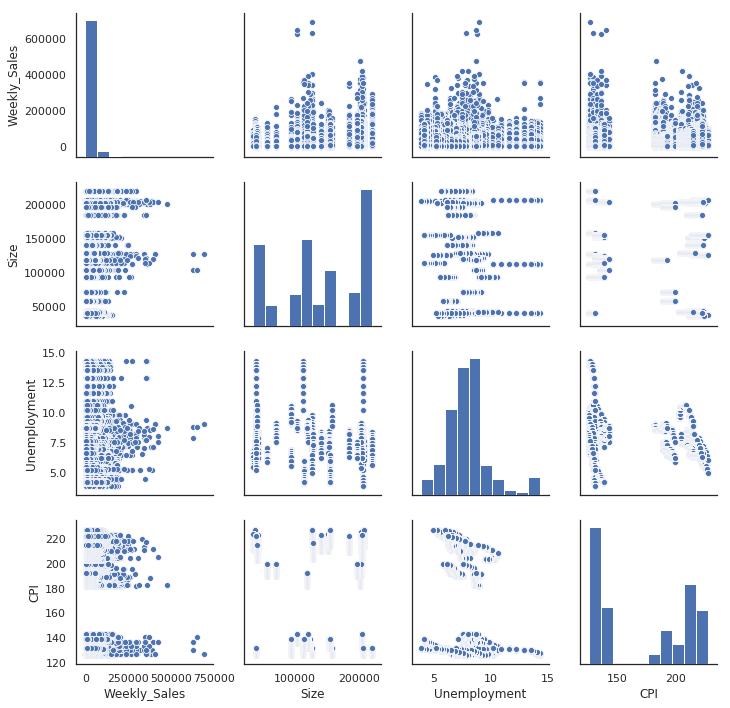

In [19]:
sns.pairplot(df_train[['Weekly_Sales', 'Size', 'Unemployment', 'CPI']])

### Outliers

Do gráfico encima podemos identificar alguns *outliers*. Vamos ver do que se trata

In [20]:
df.loc[(df['Weekly_Sales'] > 300000), 'Date'].value_counts()

2010-11-26    14
2011-11-25    13
2010-12-24     5
2011-12-23     2
Name: Date, dtype: int64

Essencialmente trata-se do `Black-Friday` e de `Natal`. Podemos usar isto para criar uma nova variavel via *one-hot encoding*

## Feature Engineering

Munidos das informações acima, vamos criar algumas features adicionais que acreditamos serão de ajuda para o modelo.
Em particular podemos criar features novas mediante:
* Usando algum tipo de encoding para as features categóricas.
* Features como temperature podem ser convertidas em categóricas: `['frio', 'morno', 'quente']``
* *mean-enconding* e outro tipo de agregações de dados númericos,  e.g., `monthly_sales`.
* *lagged features* como médias de vendas considerando as ultimas $x$ semanas.
*  *trend features* por exemplo, uma feature que tome valores em $\{-1,0,1\}$ para descrever se as vendas semanais aumentaram ou não de uma semana (mes) para outra.


### Categorical Features

Each store has a single size, so we can use a `Label Encoder`.

In [0]:
def label_enc(series):
  enc = preprocessing.LabelEncoder()
  return enc.fit_transform(series)

In [0]:
df['size_c'] = label_enc(df.Size)
df['type_c'] = label_enc(df.Type)
df['holiday_c'] = label_enc(df.IsHoliday)

In [26]:
df.head().T

,0,1,2,3,4
Store,1,1,1,1,1
Dept,1,2,3,4,5
Date,2010-02-05 00:00:00,2010-02-05 00:00:00,2010-02-05 00:00:00,2010-02-05 00:00:00,2010-02-05 00:00:00
Weekly_Sales,24924.5,50605.3,13740.1,39954,32229.4
IsHoliday,False,False,False,False,False
Temperature,42.31,42.31,42.31,42.31,42.31
Fuel_Price,2.572,2.572,2.572,2.572,2.572
MarkDown1,0,0,0,0,0
MarkDown2,0,0,0,0,0
MarkDown3,0,0,0,0,0


## Aggregate Encodings

Vamos a adicionar features que resultam de agregar os `Weekly_Sales` por distintos criterios, vamos fazer as agregações mensalmente considerando feriados.

In [27]:
by_type = df[df.train].sort_values(by = 'Date').groupby(['Type','month']).agg({'Weekly_Sales': ['mean', 'median']}).reset_index()
by_type.columns = by_type.columns.droplevel().map(str)
by_type.columns = ['Type', 'month', 'mean_t', 'median_t']
by_type.head()

,Type,month,mean_t,median_t
0,A,1,17791.673708,8049.215
1,A,2,20186.586934,10347.030
2,A,3,19382.770837,9880.860
3,A,4,19703.632700,10149.800
4,A,5,19888.484954,10382.710


In [28]:
by_store = df[df.train].sort_values(by = 'Date').groupby(['Store','month']).agg({'Weekly_Sales': ['mean', 'median']}).reset_index()
by_store.columns = by_store.columns.droplevel().map(str)
by_store.columns = ['Store', 'month', 'mean_s', 'median_s']
by_store.head()

,Store,month,mean_s,median_s
0,1,1,19586.960647,8146.42
1,1,2,22497.470104,11857.96
2,1,3,21750.978506,11336.94
3,1,4,21601.538801,10168.91
4,1,5,21669.008080,10477.28


In [29]:
by_dept = df[df.train].sort_values(by = 'Date').groupby(['Dept','month']).agg({'Weekly_Sales': ['mean', 'median']}).reset_index()
by_dept.columns = by_dept.columns.droplevel().map(str)
by_dept.columns = ['Dept', 'month', 'mean_d', 'median_d']
by_dept.head()

,Dept,month,mean_d,median_d
0,1,1,13665.363194,12673.500
1,1,2,23439.498833,19498.300
2,1,3,18478.219556,16921.260
3,1,4,27969.288698,18260.405
4,1,5,14168.030111,13442.980


We can group by several features and aggregate

In [30]:
by_holy = df[df.train].sort_values(by = 'Date').groupby(['month', 'holiday_c']).agg({'Weekly_Sales': ['mean', 'median']}).reset_index()
by_holy.columns = by_holy.columns.droplevel().map(str)
by_holy.columns = [ 'month', 'holiday_c', 'mean_h', 'median_h']
by_holy.head()

,month,holiday_c,mean_h,median_h
0,1,0,14126.075111,6134.21
1,2,0,15885.457253,7582.60
2,2,1,16377.996441,7969.23
3,3,0,15416.657597,7490.70
4,4,0,15650.338357,7634.81


In [31]:
by_sd = df[df.train].sort_values(by = 'Date').groupby(['Store', 'Dept','month']).agg({'Weekly_Sales': ['mean', 'median']}).reset_index()
by_sd.columns = by_sd.columns.droplevel().map(str)
by_sd.columns = ['Store', 'Dept', 'month', 'mean_sd', 'median_sd']
by_sd.head()


,Store,Dept,month,mean_sd,median_sd
0,1,1,1,17418.992500,17350.585
1,1,1,2,32700.750833,30956.495
2,1,1,3,22210.847692,21280.400
3,1,1,4,31512.416429,26318.080
4,1,1,5,17144.904167,17191.295


In [32]:
by_sh = df[df.train].sort_values(by = 'Date').groupby(['Store', 'month', 'holiday_c']).agg({'Weekly_Sales': ['mean', 'median']}).reset_index()
by_sh.columns = by_sh.columns.droplevel().map(str)
by_sh.columns = ['Store', 'month', 'holiday_c', 'mean_sh', 'median_sh']
by_sh.head()


,Store,month,holiday_c,mean_sh,median_sh
0,1,1,0,19586.960647,8146.42
1,1,2,0,22171.164277,11520.12
2,1,2,1,23474.883871,12977.30
3,1,3,0,21750.978506,11336.94
4,1,4,0,21601.538801,10168.91


In [33]:
by_dh = df[df.train].sort_values(by = 'Date').groupby(['Dept', 'month', 'holiday_c']).agg({'Weekly_Sales': ['mean', 'median']}).reset_index()
by_dh.columns = by_dh.columns.droplevel().map(str)
by_dh.columns = ['Dept', 'month', 'holiday_c', 'mean_dh', 'median_dh']
by_dh.head()

,Dept,month,holiday_c,mean_dh,median_dh
0,1,1,0,13665.363194,12673.500
1,1,2,0,21869.925235,17778.480
2,1,2,1,28148.219630,26220.410
3,1,3,0,18478.219556,16921.260
4,1,4,0,27969.288698,18260.405


In [34]:
by_sdh = df[df.train].sort_values(by = 'Date').groupby(['Store', 'Dept', 'month', 'holiday_c']).agg({'Weekly_Sales': ['mean', 'median']}).reset_index()
by_sdh.columns = by_sdh.columns.droplevel().map(str)
by_sdh.columns = ['Store', 'Dept', 'month', 'holiday_c', 'mean_sdh', 'median_sdh']
by_sdh.head()

,Store,Dept,month,holiday_c,mean_sdh,median_sdh
0,1,1,1,0,17418.992500,17350.585
1,1,1,2,0,30165.984444,23510.490
2,1,1,2,1,40305.050000,37887.170
3,1,1,3,0,22210.847692,21280.400
4,1,1,4,0,31512.416429,26318.080


In [35]:
by_tsdh = df[df.train].sort_values(by = 'Date').groupby(['Type','Store', 'Dept', 'month', 'holiday_c']).agg({'Weekly_Sales': ['mean', 'median']}).reset_index()
by_tsdh.columns = by_tsdh.columns.droplevel().map(str)
by_tsdh.columns = ['Type', 'Store', 'Dept', 'month', 'holiday_c', 'mean_tsdh', 'median_tsdh']
by_tsdh.head()

,Type,Store,Dept,month,holiday_c,mean_tsdh,median_tsdh
0,A,1,1,1,0,17418.992500,17350.585
1,A,1,1,2,0,30165.984444,23510.490
2,A,1,1,2,1,40305.050000,37887.170
3,A,1,1,3,0,22210.847692,21280.400
4,A,1,1,4,0,31512.416429,26318.080


Vamos incluir estas novas features usando merge

In [0]:
df = df.merge(by_type, how = 'outer', on = ['Type', 'month'])
df = df.merge(by_store, how = 'outer', on =['Store','month'])
df = df.merge(by_dept, how = 'outer', on =['Dept','month'])
df = df.merge(by_holy, how = 'outer', on =['month', 'holiday_c'])
df = df.merge(by_sh, how = 'outer', on =['Store', 'month', 'holiday_c'])
df = df.merge(by_sd, how = 'outer', on =['Store', 'Dept', 'month'])
df = df.merge(by_dh, how = 'outer', on =['Dept', 'month', 'holiday_c'])
df = df.merge(by_sdh, how = 'outer', on =['Store', 'Dept', 'month', 'holiday_c'])
df = df.merge(by_tsdh, how = 'outer', on =['Type', 'Store', 'Dept', 'month', 'holiday_c'])


In [37]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,year,month,week,train,size_c,type_c,holiday_c,mean_t,median_t,mean_s,median_s,mean_d,median_d,mean_h,median_h,mean_sh,median_sh,mean_sd,median_sd,mean_dh,median_dh,mean_sdh,median_sdh,mean_tsdh,median_tsdh
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,True,21,0,0,20186.586934,10347.03,22497.470104,11857.96,23439.498833,19498.3,15885.457253,7582.6,22171.164277,11520.12,32700.750833,30956.495,21869.925235,17778.48,30165.984444,23510.49,30165.984444,23510.49
1,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315,2010,2,7,True,21,0,0,20186.586934,10347.03,22497.470104,11857.96,23439.498833,19498.3,15885.457253,7582.6,22171.164277,11520.12,32700.750833,30956.495,21869.925235,17778.48,30165.984444,23510.49,30165.984444,23510.49
2,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315,2010,2,8,True,21,0,0,20186.586934,10347.03,22497.470104,11857.96,23439.498833,19498.3,15885.457253,7582.6,22171.164277,11520.12,32700.750833,30956.495,21869.925235,17778.48,30165.984444,23510.49,30165.984444,23510.49
3,1,1,2011-02-04,21665.76,False,42.27,2.989,0.0,0.0,0.0,0.0,0.0,212.566881,7.742,A,151315,2011,2,5,True,21,0,0,20186.586934,10347.03,22497.470104,11857.96,23439.498833,19498.3,15885.457253,7582.6,22171.164277,11520.12,32700.750833,30956.495,21869.925235,17778.48,30165.984444,23510.49,30165.984444,23510.49
4,1,1,2011-02-18,46845.87,False,57.36,3.045,0.0,0.0,0.0,0.0,0.0,213.247885,7.742,A,151315,2011,2,7,True,21,0,0,20186.586934,10347.03,22497.470104,11857.96,23439.498833,19498.3,15885.457253,7582.6,22171.164277,11520.12,32700.750833,30956.495,21869.925235,17778.48,30165.984444,23510.49,30165.984444,23510.49


# Modeling
We will start with XGBoost


In [0]:
cols = [
    'Store',
    'Dept',
    'Temperature',
    'Fuel_Price',
    'MarkDown1', 
    'MarkDown2', 
    'MarkDown3', 
    'MarkDown4',
    'MarkDown5', 
    'CPI', 
    'Unemployment',
    'month',
    'week',
    'size_c', 
    'type_c', 
    'holiday_c', 
    'mean_t', 'mean_s', 'mean_d', 'mean_h', 'mean_sh', 'mean_sd', 'mean_dh', 'mean_sdh',
    'median_t','median_s', 'median_d',  'median_h','median_sh',  'median_sd',  'median_dh',
     'median_sdh', 'mean_tsdh', 'median_tsdh'

]

In [0]:
# split the dataframe into data_df and test_df
data_df = df[df.train]

test_df = df[~df.train]

`data_df` has to be split into train/validation for model assesment purposes

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(data_df[cols], data_df['Weekly_Sales'], test_size=0.2, random_state=42)
X_test = test_df[cols]

In [0]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

In [42]:
model.fit(
    X_train, 
    y_train, 
    eval_metric="mae", 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=False, 
    early_stopping_rounds = 10,
    callbacks=[xgb.callback.print_evaluation(period=10)])

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:04:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:14383.3	validation_1-mae:14390.6
[10]	validation_0-mae:5100.31	validation_1-mae:5106.15
[20]	validation_0-mae:2220.43	validation_1-mae:2228.11
[30]	validation_0-mae:1611.36	validation_1-mae:1623.85
[40]	validation_0-mae:1516.77	validation_1-mae:1534.27
[50]	validation_0-mae:1498.63	validation_1-mae:1516.92
[60]	validation_0-mae:1484.32	validation_1-mae:1503.53
[70]	validation_0-mae:1478.91	validation_1-mae:1498.66
[80]	validation_0-mae:1471.8	validation_1-mae:1491.56
[90]	validation_0-mae:1463.54	validation_1-mae:1483.54
[100]	validation_0-mae:1458.69	validation_1-mae:1479.08
[110]	validation_0-mae:1455.73	validation_1-mae:1476.63
[120]	validation_0-mae:1449.18	validation_1-mae:1470.98
[130]	validation_0-mae:1446.38	validation_1-mae:1468.97
[140]	validation_0-mae:1442.31	validation_1-mae:1464.67
[150]	validation_0-mae:1439.52	validation_1-m

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=300, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

In [0]:
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_pred = model.predict(X_test)

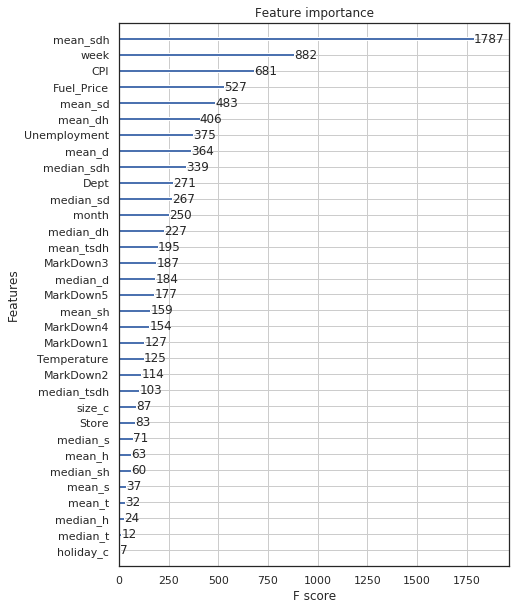

In [44]:
plot_features(model, (7,10))


In [45]:
print('Train mae: {}'.format(mean_absolute_error(y_train, y_train_pred)))
print('Valid mae: {}'.format(mean_absolute_error(y_valid, y_valid_pred)))

Train mae: 1413.0135754045384
Valid mae: 1441.0183436777545


As predições sobre os dados de Teste:

In [50]:
y_pred.shape

(115064,)

In [56]:
output = test_df[['Store', 'Dept', 'Date']]
output['pred_weekly_sales'] = y_pred
output.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Store,Dept,Date,pred_weekly_sales
9,1,1,2013-02-01,31660.064453
10,1,1,2013-02-15,30362.494141
11,1,1,2013-02-22,29879.140625
21,2,1,2013-02-01,42107.445312
22,2,1,2013-02-15,43496.417969


In [57]:
output

,Store,Dept,Date,pred_weekly_sales
9,1,1,2013-02-01,31660.064453
10,1,1,2013-02-15,30362.494141
11,1,1,2013-02-22,29879.140625
21,2,1,2013-02-01,42107.445312
22,2,1,2013-02-15,43496.417969
23,2,1,2013-02-22,40106.175781
33,4,1,2013-02-01,45834.960938
34,4,1,2013-02-15,47117.679688
35,4,1,2013-02-22,45900.609375
45,6,1,2013-02-01,28017.914062
